This notebook is based on `5.0-ayw-neural-network.ipynb`

## Aim of this notebook

In this notebook we will use a fully connected neural network with 6 hidden layers with each layer having 1825 nodes. All five dataset will be examined separately.

## Results

The simple neural network is unable to detect degradation rates from a normalised power signal to any reasonable precision for all datasets except for basic. Note that soil_weather_extra dataset seem to perform better than soil, weather, or soil_weather. 

As a consequence such neural network can't be used as a stand-alone tool to analyse degradation, however it might be useful in a CODS like pipline, where other methods are used to clean up the data passed to the neural network.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import os
import datetime
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

import tensorflow as tf

from src.models.prepare_model import load_PI_data, split_data_training, create_fully_connected_model
from src.models.train_model import train_model
from src.models.predict_model import load_and_predict_model

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
def extract_yr_degrad(avg_power_decay):
    x = np.array([i/365 for i in range(0,len(avg_power_decay))])
    y = np.array(avg_power_decay)
    return np.polyfit(x,y,1)[0]

## Test all of the datasets

In [3]:
# Set up the variables
datasets = [
    ('../data/processed/synthetic_basic_pi_daily.zip', 'basic', 50),
    ('../data/processed/synthetic_soil_pi_daily.zip', 'soil', 50),
    ('../data/processed/synthetic_weather_pi_daily.zip', 'weather', 50),
    ('../data/processed/synthetic_soil_weather_pi_daily.zip', 'soil_weather', 50),
    ('../data/processed/synthetic_soil_weather_pi_daily_extra.zip', 'soil_weather_extra', 100)]

name = 'fc_6_layers'
signal_length = 1825
nr_epochs = 1000
hidden_layers = [signal_length] * 5

X_tests = {}
y_tests = {}
predictions = {}
ys = {}
rmses = {}

In [4]:
# Run
for dataset in datasets:
    print(f"Processing {dataset[1]}\n")
    
    # Read in the data
    X, y = load_PI_data(dataset[0], dataset[2], 5)
    X_train, X_valid, X_test, y_train, y_valid, y_test = split_data_training(X, y)
    X_tests[dataset[1]] = X_test
    y_tests[dataset[1]] = y_test
    
    # Create the model
    model = create_fully_connected_model(signal_length, signal_length, hidden_layers)
    model_name = name + '_' + dataset[1]
    
    # Get run index
    run_index_path = "./checkpoint/run_index"

    with open(run_index_path, 'r') as f:
        run_index = int(f.readline())
    run_index += 1
    with open(run_index_path, 'w') as f:
        f.write(str(run_index))
    
    # Train the model
    checpoint_path = train_model(model,
                                 X_train,
                                 y_train,
                                 X_valid,
                                 y_valid,
                                 run_index,
                                 model_name,
                                 "./log/" + dataset[1],
                                 "./checkpoint/" + dataset[1],
                                 nr_epochs)
    print(f"Checkpoint for {dataset[1]} dataset is at {checpoint_path}")
    
    # Predict on 
    prediction = load_and_predict_model(checpoint_path, X_test)
    
    # Find RMSE
    model_pred = []
    degradation_rates_test = []
    for i in range(0, len(prediction)):
        model_pred.append(extract_yr_degrad(prediction[i, :]))
        degradation_rates_test.append(extract_yr_degrad(y_test[i]))
    mse = mean_squared_error(model_pred, degradation_rates_test)
    
    rmses[dataset[1]] = np.sqrt(mse)
    print(f"RMSE for {dataset[1]} dataset is at {rmses[dataset[1]]}")    
    predictions[dataset[1]] = prediction
    ys[dataset[1]] = y_test

Processing basic

Epoch 1/1000
2/2 [==============================] - 0s 189ms/step - loss: 0.2937 - val_loss: 0.4343
Epoch 2/1000
2/2 [==============================] - 0s 60ms/step - loss: 0.2890 - val_loss: 0.5008
Epoch 3/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.2815 - val_loss: 0.5340
Epoch 4/1000
2/2 [==============================] - 0s 60ms/step - loss: 0.2656 - val_loss: 0.5570
Epoch 5/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.2560 - val_loss: 0.5352
Epoch 6/1000
2/2 [==============================] - 0s 67ms/step - loss: 0.2460 - val_loss: 0.5413
Epoch 7/1000
2/2 [==============================] - 0s 60ms/step - loss: 0.2383 - val_loss: 0.5351
Epoch 8/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.2331 - val_loss: 0.5333
Epoch 9/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.2276 - val_loss: 0.5151
Epoch 10/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.2241 - val_los

2/2 [==============================] - 0s 60ms/step - loss: 5.6772e-04 - val_loss: 5.2792e-04
Epoch 81/1000
2/2 [==============================] - 0s 54ms/step - loss: 5.5186e-04 - val_loss: 5.0799e-04
Epoch 82/1000
2/2 [==============================] - 0s 57ms/step - loss: 5.3771e-04 - val_loss: 4.8487e-04
Epoch 83/1000
2/2 [==============================] - 0s 63ms/step - loss: 5.1727e-04 - val_loss: 4.5603e-04
Epoch 84/1000
2/2 [==============================] - 0s 60ms/step - loss: 5.0159e-04 - val_loss: 4.3287e-04
Epoch 85/1000
2/2 [==============================] - 0s 62ms/step - loss: 4.8509e-04 - val_loss: 4.1525e-04
Epoch 86/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.6638e-04 - val_loss: 3.9246e-04
Epoch 87/1000
2/2 [==============================] - 0s 58ms/step - loss: 4.5163e-04 - val_loss: 3.6387e-04
Epoch 88/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.3784e-04 - val_loss: 3.4255e-04
Epoch 89/1000
2/2 [=======================

2/2 [==============================] - 0s 58ms/step - loss: 1.1710e-04 - val_loss: 1.2557e-04
Epoch 153/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.2008e-04 - val_loss: 1.2406e-04
Epoch 154/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.1708e-04 - val_loss: 1.2263e-04
Epoch 155/1000
2/2 [==============================] - 0s 61ms/step - loss: 1.1441e-04 - val_loss: 1.2113e-04
Epoch 156/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.1186e-04 - val_loss: 1.2012e-04
Epoch 157/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.1166e-04 - val_loss: 1.1979e-04
Epoch 158/1000
2/2 [==============================] - 0s 60ms/step - loss: 1.0890e-04 - val_loss: 1.1867e-04
Epoch 159/1000
2/2 [==============================] - 0s 60ms/step - loss: 1.0989e-04 - val_loss: 1.1690e-04
Epoch 160/1000
2/2 [==============================] - 0s 63ms/step - loss: 1.0787e-04 - val_loss: 1.1484e-04
Epoch 161/1000
2/2 [==============

2/2 [==============================] - 0s 56ms/step - loss: 4.9622e-05 - val_loss: 7.3571e-05
Epoch 226/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.8122e-05 - val_loss: 6.8371e-05
Epoch 227/1000
2/2 [==============================] - 0s 122ms/step - loss: 4.7591e-05 - val_loss: 6.4820e-05
Epoch 228/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.7209e-05 - val_loss: 6.3975e-05
Epoch 229/1000
2/2 [==============================] - 0s 61ms/step - loss: 4.7439e-05 - val_loss: 6.4219e-05
Epoch 230/1000
2/2 [==============================] - 0s 57ms/step - loss: 5.1580e-05 - val_loss: 6.2533e-05
Epoch 231/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.6545e-05 - val_loss: 6.0490e-05
Epoch 232/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.6199e-05 - val_loss: 5.9216e-05
Epoch 233/1000
2/2 [==============================] - 0s 58ms/step - loss: 4.8982e-05 - val_loss: 5.9366e-05
Epoch 234/1000
2/2 [=============

2/2 [==============================] - 0s 59ms/step - loss: 2.8113e-05 - val_loss: 2.8090e-05
Epoch 299/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.7069e-05 - val_loss: 2.7870e-05
Epoch 300/1000
2/2 [==============================] - 4s 2s/step - loss: 2.6155e-05 - val_loss: 2.7528e-05
Epoch 301/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.8804e-05 - val_loss: 2.7437e-05
Epoch 302/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.5802e-05 - val_loss: 2.6845e-05
Epoch 303/1000
2/2 [==============================] - 0s 64ms/step - loss: 2.4843e-05 - val_loss: 2.6457e-05
Epoch 304/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.8276e-05 - val_loss: 2.5892e-05
Epoch 305/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.8018e-05 - val_loss: 2.5992e-05
Epoch 306/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.5796e-05 - val_loss: 2.6484e-05
Epoch 307/1000
2/2 [================

Epoch 370/1000
2/2 [==============================] - 0s 63ms/step - loss: 1.7851e-05 - val_loss: 1.5324e-05
Epoch 371/1000
2/2 [==============================] - 0s 62ms/step - loss: 2.1072e-05 - val_loss: 1.5341e-05
Epoch 372/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.2262e-05 - val_loss: 1.5274e-05
Epoch 373/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.8613e-05 - val_loss: 1.5492e-05
Epoch 374/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.6648e-05 - val_loss: 1.6740e-05
Epoch 375/1000
2/2 [==============================] - 0s 62ms/step - loss: 1.8466e-05 - val_loss: 1.6694e-05
Epoch 376/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.9667e-05 - val_loss: 1.5893e-05
Epoch 377/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.6962e-05 - val_loss: 1.5470e-05
Epoch 378/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.7290e-05 - val_loss: 1.4924e-05
Epoch 379/1000
2/2 

2/2 [==============================] - 0s 60ms/step - loss: 1.4292e-05 - val_loss: 1.3795e-05
Epoch 444/1000
2/2 [==============================] - 0s 60ms/step - loss: 1.5142e-05 - val_loss: 1.3350e-05
Epoch 445/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.4701e-05 - val_loss: 1.1722e-05
Epoch 446/1000
2/2 [==============================] - 0s 62ms/step - loss: 1.3040e-05 - val_loss: 1.0859e-05
Epoch 447/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.2520e-05 - val_loss: 1.0595e-05
Epoch 448/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.3137e-05 - val_loss: 1.0737e-05
Epoch 449/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.2477e-05 - val_loss: 1.0761e-05
Epoch 450/1000
2/2 [==============================] - 4s 2s/step - loss: 1.2005e-05 - val_loss: 1.0596e-05
Epoch 451/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.4544e-05 - val_loss: 1.0477e-05
Epoch 452/1000
2/2 [================

Epoch 515/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.1581e-05 - val_loss: 7.7288e-06
Epoch 516/1000
2/2 [==============================] - 0s 57ms/step - loss: 9.8339e-06 - val_loss: 7.7786e-06
Epoch 517/1000
2/2 [==============================] - 0s 61ms/step - loss: 7.9985e-06 - val_loss: 7.8774e-06
Epoch 518/1000
2/2 [==============================] - 0s 62ms/step - loss: 8.1020e-06 - val_loss: 8.0129e-06
Epoch 519/1000
2/2 [==============================] - 0s 61ms/step - loss: 1.2694e-05 - val_loss: 8.0817e-06
Epoch 520/1000
2/2 [==============================] - 0s 58ms/step - loss: 8.4955e-06 - val_loss: 8.2771e-06
Epoch 521/1000
2/2 [==============================] - 0s 65ms/step - loss: 7.6716e-06 - val_loss: 8.1692e-06
Epoch 522/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.3774e-05 - val_loss: 8.3502e-06
Epoch 523/1000
2/2 [==============================] - 0s 64ms/step - loss: 9.4251e-06 - val_loss: 8.8844e-06
Epoch 524/1000
2/2 

2/2 [==============================] - 0s 59ms/step - loss: 6.2521e-06 - val_loss: 5.5196e-06
Epoch 589/1000
2/2 [==============================] - 0s 57ms/step - loss: 9.9514e-06 - val_loss: 5.7432e-06
Epoch 590/1000
2/2 [==============================] - 0s 60ms/step - loss: 7.8039e-06 - val_loss: 5.9812e-06
Epoch 591/1000
2/2 [==============================] - 0s 57ms/step - loss: 7.0976e-06 - val_loss: 5.9368e-06
Epoch 592/1000
2/2 [==============================] - 0s 59ms/step - loss: 6.7056e-06 - val_loss: 5.8904e-06
Epoch 593/1000
2/2 [==============================] - 0s 59ms/step - loss: 8.9752e-06 - val_loss: 5.7187e-06
Epoch 594/1000
2/2 [==============================] - 0s 55ms/step - loss: 1.5934e-05 - val_loss: 5.3666e-06
Epoch 595/1000
2/2 [==============================] - 0s 58ms/step - loss: 9.5738e-06 - val_loss: 6.1389e-06
Epoch 596/1000
2/2 [==============================] - 0s 61ms/step - loss: 1.0007e-05 - val_loss: 7.3412e-06
Epoch 597/1000
2/2 [==============

Epoch 660/1000
2/2 [==============================] - 0s 58ms/step - loss: 5.0812e-06 - val_loss: 5.3475e-06
Epoch 661/1000
2/2 [==============================] - 0s 58ms/step - loss: 9.1920e-06 - val_loss: 5.6226e-06
Epoch 662/1000
2/2 [==============================] - 0s 55ms/step - loss: 7.9554e-06 - val_loss: 6.6878e-06
Epoch 663/1000
2/2 [==============================] - 0s 56ms/step - loss: 7.1277e-06 - val_loss: 8.1647e-06
Epoch 664/1000
2/2 [==============================] - 0s 58ms/step - loss: 8.8239e-06 - val_loss: 9.4446e-06
Epoch 665/1000
2/2 [==============================] - 0s 56ms/step - loss: 9.9810e-06 - val_loss: 8.3564e-06
Epoch 666/1000
2/2 [==============================] - 0s 60ms/step - loss: 9.2246e-06 - val_loss: 6.1154e-06
Epoch 667/1000
2/2 [==============================] - 0s 58ms/step - loss: 8.2189e-06 - val_loss: 5.0615e-06
Epoch 668/1000
2/2 [==============================] - 0s 56ms/step - loss: 6.2558e-06 - val_loss: 4.8172e-06
Epoch 669/1000
2/2 

2/2 [==============================] - 0s 63ms/step - loss: 5.7140e-06 - val_loss: 3.9781e-06
Epoch 734/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.6926e-06 - val_loss: 4.5008e-06
Epoch 735/1000
2/2 [==============================] - 0s 58ms/step - loss: 5.8873e-06 - val_loss: 4.9716e-06
Epoch 736/1000
2/2 [==============================] - 0s 55ms/step - loss: 5.8818e-06 - val_loss: 4.2105e-06
Epoch 737/1000
2/2 [==============================] - 0s 55ms/step - loss: 6.5780e-06 - val_loss: 4.1479e-06
Epoch 738/1000
2/2 [==============================] - 0s 59ms/step - loss: 5.6307e-06 - val_loss: 3.9631e-06
Epoch 739/1000
2/2 [==============================] - 0s 59ms/step - loss: 4.7084e-06 - val_loss: 3.7385e-06
Epoch 740/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.7804e-06 - val_loss: 4.5369e-06
Epoch 741/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.9038e-06 - val_loss: 5.3732e-06
Epoch 742/1000
2/2 [==============

Epoch 805/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.9127e-06 - val_loss: 4.4836e-06
Epoch 806/1000
2/2 [==============================] - 0s 58ms/step - loss: 8.2587e-06 - val_loss: 5.2456e-06
Epoch 807/1000
2/2 [==============================] - 0s 63ms/step - loss: 6.4967e-06 - val_loss: 5.4706e-06
Epoch 808/1000
2/2 [==============================] - 0s 57ms/step - loss: 6.1360e-06 - val_loss: 6.8575e-06
Epoch 809/1000
2/2 [==============================] - 0s 64ms/step - loss: 7.5784e-06 - val_loss: 6.0091e-06
Epoch 810/1000
2/2 [==============================] - 0s 57ms/step - loss: 5.2490e-06 - val_loss: 3.9228e-06
Epoch 811/1000
2/2 [==============================] - 0s 60ms/step - loss: 5.6539e-06 - val_loss: 3.9356e-06
Epoch 812/1000
2/2 [==============================] - 0s 56ms/step - loss: 9.7053e-06 - val_loss: 4.2543e-06
Epoch 813/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.3113e-05 - val_loss: 4.7789e-06
Epoch 814/1000
2/2 

2/2 [==============================] - 0s 60ms/step - loss: 9.3755e-06 - val_loss: 1.2072e-05
Epoch 879/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.0566e-05 - val_loss: 1.1351e-05
Epoch 880/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.0244e-05 - val_loss: 7.5731e-06
Epoch 881/1000
2/2 [==============================] - 0s 57ms/step - loss: 7.6926e-06 - val_loss: 4.7387e-06
Epoch 882/1000
2/2 [==============================] - 0s 59ms/step - loss: 6.0827e-06 - val_loss: 3.5622e-06
Epoch 883/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.5705e-06 - val_loss: 3.7351e-06
Epoch 884/1000
2/2 [==============================] - 0s 55ms/step - loss: 5.1986e-06 - val_loss: 5.1007e-06
Epoch 885/1000
2/2 [==============================] - 0s 58ms/step - loss: 7.0008e-06 - val_loss: 5.2628e-06
Epoch 886/1000
2/2 [==============================] - 0s 58ms/step - loss: 6.4233e-06 - val_loss: 3.4089e-06
Epoch 887/1000
2/2 [==============

2/2 [==============================] - 4s 2s/step - loss: 6.0213e-06 - val_loss: 3.2456e-06
Epoch 951/1000
2/2 [==============================] - 0s 57ms/step - loss: 6.2161e-06 - val_loss: 4.6065e-06
Epoch 952/1000
2/2 [==============================] - 0s 66ms/step - loss: 7.0169e-06 - val_loss: 4.7977e-06
Epoch 953/1000
2/2 [==============================] - 0s 55ms/step - loss: 9.4973e-06 - val_loss: 3.6889e-06
Epoch 954/1000
2/2 [==============================] - 0s 59ms/step - loss: 5.1634e-06 - val_loss: 2.8443e-06
Epoch 955/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.0803e-05 - val_loss: 2.8914e-06
Epoch 956/1000
2/2 [==============================] - 0s 58ms/step - loss: 6.7690e-06 - val_loss: 3.4337e-06
Epoch 957/1000
2/2 [==============================] - 0s 62ms/step - loss: 9.0729e-06 - val_loss: 2.2835e-06
Epoch 958/1000
2/2 [==============================] - 0s 58ms/step - loss: 6.0968e-06 - val_loss: 4.3144e-06
Epoch 959/1000
2/2 [================

2/2 [==============================] - 0s 61ms/step - loss: 0.1824 - val_loss: 0.6222
Epoch 25/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.1747 - val_loss: 0.6022
Epoch 26/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.1677 - val_loss: 0.6170
Epoch 27/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.1599 - val_loss: 0.6556
Epoch 28/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.1601 - val_loss: 0.5477
Epoch 29/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.1943 - val_loss: 0.6561
Epoch 30/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.1605 - val_loss: 0.6707
Epoch 31/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.1412 - val_loss: 0.6385
Epoch 32/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.1355 - val_loss: 0.6098
Epoch 33/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.1227 - val_loss: 0.5587
Epoch 34/1000


Epoch 101/1000
2/2 [==============================] - 0s 56ms/step - loss: 7.1603e-04 - val_loss: 4.8612e-04
Epoch 102/1000
2/2 [==============================] - 0s 57ms/step - loss: 5.7218e-04 - val_loss: 5.2277e-04
Epoch 103/1000
2/2 [==============================] - 0s 58ms/step - loss: 5.8669e-04 - val_loss: 5.2164e-04
Epoch 104/1000
2/2 [==============================] - 0s 58ms/step - loss: 5.9755e-04 - val_loss: 4.7098e-04
Epoch 105/1000
2/2 [==============================] - 0s 58ms/step - loss: 5.4923e-04 - val_loss: 4.3418e-04
Epoch 106/1000
2/2 [==============================] - 0s 60ms/step - loss: 5.4303e-04 - val_loss: 4.2288e-04
Epoch 107/1000
2/2 [==============================] - 0s 157ms/step - loss: 5.0366e-04 - val_loss: 4.1661e-04
Epoch 108/1000
2/2 [==============================] - 0s 58ms/step - loss: 4.7551e-04 - val_loss: 4.0904e-04
Epoch 109/1000
2/2 [==============================] - 0s 62ms/step - loss: 4.5062e-04 - val_loss: 4.0467e-04
Epoch 110/1000
2/2

2/2 [==============================] - 0s 55ms/step - loss: 5.9086e-04 - val_loss: 0.0013
Epoch 177/1000
2/2 [==============================] - 0s 58ms/step - loss: 6.7182e-04 - val_loss: 0.0016
Epoch 178/1000
2/2 [==============================] - 0s 57ms/step - loss: 5.2621e-04 - val_loss: 0.0024
Epoch 179/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.7559e-04 - val_loss: 0.0034
Epoch 180/1000
2/2 [==============================] - 0s 61ms/step - loss: 4.7781e-04 - val_loss: 0.0031
Epoch 181/1000
2/2 [==============================] - 0s 59ms/step - loss: 5.6431e-04 - val_loss: 0.0019
Epoch 182/1000
2/2 [==============================] - 0s 57ms/step - loss: 5.2466e-04 - val_loss: 0.0013
Epoch 183/1000
2/2 [==============================] - 0s 64ms/step - loss: 4.1499e-04 - val_loss: 9.1407e-04
Epoch 184/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.8094e-04 - val_loss: 7.5946e-04
Epoch 185/1000
2/2 [==============================] - 0s 57ms/

Epoch 250/1000
2/2 [==============================] - 4s 2s/step - loss: 0.0010 - val_loss: 4.0299e-04
Epoch 251/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.8667e-04 - val_loss: 3.0335e-04
Epoch 252/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.0703e-04 - val_loss: 3.6590e-04
Epoch 253/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.5145e-04 - val_loss: 4.0990e-04
Epoch 254/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.5625e-04 - val_loss: 4.9453e-04
Epoch 255/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.4965e-04 - val_loss: 5.8878e-04
Epoch 256/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.4899e-04 - val_loss: 7.4506e-04
Epoch 257/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.3862e-04 - val_loss: 8.5381e-04
Epoch 258/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.4374e-04 - val_loss: 8.5222e-04
Epoch 259/1000
2/2 [=====

Epoch 322/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.6482e-04 - val_loss: 5.1079e-04
Epoch 323/1000
2/2 [==============================] - 0s 64ms/step - loss: 2.7437e-04 - val_loss: 5.2220e-04
Epoch 324/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.5853e-04 - val_loss: 5.2740e-04
Epoch 325/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.6174e-04 - val_loss: 5.2097e-04
Epoch 326/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.6519e-04 - val_loss: 5.1347e-04
Epoch 327/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.6221e-04 - val_loss: 4.9435e-04
Epoch 328/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.7273e-04 - val_loss: 4.8663e-04
Epoch 329/1000
2/2 [==============================] - 0s 57ms/step - loss: 5.6832e-04 - val_loss: 4.1395e-04
Epoch 330/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.5591e-04 - val_loss: 4.1068e-04
Epoch 331/1000
2/2 

2/2 [==============================] - 0s 58ms/step - loss: 2.3516e-04 - val_loss: 4.1411e-04
Epoch 396/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.5593e-04 - val_loss: 4.3063e-04
Epoch 397/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.3389e-04 - val_loss: 4.3859e-04
Epoch 398/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.2643e-04 - val_loss: 4.4203e-04
Epoch 399/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.2691e-04 - val_loss: 4.3604e-04
Epoch 400/1000
2/2 [==============================] - 4s 2s/step - loss: 2.2246e-04 - val_loss: 4.3016e-04
Epoch 401/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.3131e-04 - val_loss: 4.2295e-04
Epoch 402/1000
2/2 [==============================] - 0s 61ms/step - loss: 2.2302e-04 - val_loss: 4.0882e-04
Epoch 403/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.2488e-04 - val_loss: 3.9248e-04
Epoch 404/1000
2/2 [================

Epoch 467/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.1285e-04 - val_loss: 4.4116e-04
Epoch 468/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.3590e-04 - val_loss: 4.3219e-04
Epoch 469/1000
2/2 [==============================] - 0s 62ms/step - loss: 4.6419e-04 - val_loss: 4.2955e-04
Epoch 470/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.5055e-04 - val_loss: 4.5405e-04
Epoch 471/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.2354e-04 - val_loss: 4.8501e-04
Epoch 472/1000
2/2 [==============================] - 0s 62ms/step - loss: 2.4915e-04 - val_loss: 5.1567e-04
Epoch 473/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.6628e-04 - val_loss: 5.4307e-04
Epoch 474/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.5139e-04 - val_loss: 5.8643e-04
Epoch 475/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.5252e-04 - val_loss: 6.3910e-04
Epoch 476/1000
2/2 

2/2 [==============================] - 0s 58ms/step - loss: 2.0757e-04 - val_loss: 4.1741e-04
Epoch 541/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.1099e-04 - val_loss: 4.1888e-04
Epoch 542/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.1226e-04 - val_loss: 4.1325e-04
Epoch 543/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.0666e-04 - val_loss: 4.2571e-04
Epoch 544/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.0407e-04 - val_loss: 4.4579e-04
Epoch 545/1000
2/2 [==============================] - 0s 61ms/step - loss: 2.6014e-04 - val_loss: 4.2227e-04
Epoch 546/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.1881e-04 - val_loss: 4.0775e-04
Epoch 547/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.0925e-04 - val_loss: 4.1265e-04
Epoch 548/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.1341e-04 - val_loss: 4.1639e-04
Epoch 549/1000
2/2 [==============

Epoch 65/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.0022 - val_loss: 0.0364
Epoch 66/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.0020 - val_loss: 0.0293
Epoch 67/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.0019 - val_loss: 0.0174
Epoch 68/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.0019 - val_loss: 0.0118
Epoch 69/1000
2/2 [==============================] - 0s 54ms/step - loss: 0.0019 - val_loss: 0.0097
Epoch 70/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.0016 - val_loss: 0.0076
Epoch 71/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.0016 - val_loss: 0.0062
Epoch 72/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 73/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 74/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.0016 - val_loss: 0.0047


2/2 [==============================] - 0s 58ms/step - loss: 3.3695e-04 - val_loss: 7.7657e-04
Epoch 143/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.1867e-04 - val_loss: 7.3222e-04
Epoch 144/1000
2/2 [==============================] - 0s 62ms/step - loss: 2.9399e-04 - val_loss: 7.3037e-04
Epoch 145/1000
2/2 [==============================] - 0s 63ms/step - loss: 3.3683e-04 - val_loss: 7.1743e-04
Epoch 146/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.7825e-04 - val_loss: 6.9655e-04
Epoch 147/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.7955e-04 - val_loss: 6.8788e-04
Epoch 148/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.6825e-04 - val_loss: 6.8932e-04
Epoch 149/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.8332e-04 - val_loss: 6.8273e-04
Epoch 150/1000
2/2 [==============================] - 4s 2s/step - loss: 3.2444e-04 - val_loss: 6.7070e-04
Epoch 151/1000
2/2 [================

Epoch 214/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.1192e-04 - val_loss: 5.9450e-04
Epoch 215/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.8278e-04 - val_loss: 6.1088e-04
Epoch 216/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.8527e-04 - val_loss: 6.1442e-04
Epoch 217/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.9623e-04 - val_loss: 6.0111e-04
Epoch 218/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.8727e-04 - val_loss: 5.9976e-04
Epoch 219/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.7784e-04 - val_loss: 5.9607e-04
Epoch 220/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.8332e-04 - val_loss: 6.0736e-04
Epoch 221/1000
2/2 [==============================] - 0s 62ms/step - loss: 1.7469e-04 - val_loss: 6.0417e-04
Epoch 222/1000
2/2 [==============================] - 0s 62ms/step - loss: 1.8946e-04 - val_loss: 5.9668e-04
Epoch 223/1000
2/2 

2/2 [==============================] - 0s 57ms/step - loss: 1.9732e-04 - val_loss: 8.0696e-04
Epoch 288/1000
2/2 [==============================] - 0s 58ms/step - loss: 4.8900e-04 - val_loss: 8.7045e-04
Epoch 289/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.2746e-04 - val_loss: 0.0013
Epoch 290/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.1495e-04 - val_loss: 0.0014
Epoch 291/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.2769e-04 - val_loss: 0.0014
Epoch 292/1000
2/2 [==============================] - 0s 53ms/step - loss: 2.3958e-04 - val_loss: 0.0012
Epoch 293/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.4813e-04 - val_loss: 0.0011
Epoch 294/1000
2/2 [==============================] - 0s 56ms/step - loss: 3.2868e-04 - val_loss: 0.0011
Epoch 295/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.5762e-04 - val_loss: 0.0012
Epoch 296/1000
2/2 [==============================] - 0s 58ms/

2/2 [==============================] - 0s 60ms/step - loss: 2.6738e-04 - val_loss: 4.7316e-04
Epoch 360/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.3437e-04 - val_loss: 4.4029e-04
Epoch 361/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.0875e-04 - val_loss: 4.4047e-04
Epoch 362/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.0709e-04 - val_loss: 4.4611e-04
Epoch 363/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.1183e-04 - val_loss: 4.4730e-04
Epoch 364/1000
2/2 [==============================] - 0s 62ms/step - loss: 2.1411e-04 - val_loss: 4.3754e-04
Epoch 365/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.6000e-04 - val_loss: 4.2109e-04
Epoch 366/1000
2/2 [==============================] - 0s 65ms/step - loss: 2.1833e-04 - val_loss: 4.0638e-04
Epoch 367/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.0094e-04 - val_loss: 4.0037e-04
Epoch 368/1000
2/2 [==============

2/2 [==============================] - 0s 130ms/step - loss: 2.0698e-04 - val_loss: 4.3641e-04
Epoch 433/1000
2/2 [==============================] - 0s 62ms/step - loss: 1.9819e-04 - val_loss: 4.1749e-04
Epoch 434/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.2552e-04 - val_loss: 3.8274e-04
Epoch 435/1000
2/2 [==============================] - 0s 60ms/step - loss: 1.9518e-04 - val_loss: 3.8859e-04
Epoch 436/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.0022e-04 - val_loss: 3.9536e-04
Epoch 437/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.0644e-04 - val_loss: 4.0046e-04
Epoch 438/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.0509e-04 - val_loss: 3.9576e-04
Epoch 439/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.9766e-04 - val_loss: 4.0220e-04
Epoch 440/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.9922e-04 - val_loss: 3.9838e-04
Epoch 441/1000
2/2 [=============

Epoch 504/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.1631e-04 - val_loss: 4.9816e-04
Epoch 505/1000
2/2 [==============================] - 0s 62ms/step - loss: 2.1323e-04 - val_loss: 4.5973e-04
Epoch 506/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.1879e-04 - val_loss: 4.1651e-04
Epoch 507/1000
2/2 [==============================] - 0s 61ms/step - loss: 2.1419e-04 - val_loss: 3.8562e-04
Epoch 508/1000
2/2 [==============================] - 0s 62ms/step - loss: 2.1173e-04 - val_loss: 3.6696e-04
Epoch 509/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.0580e-04 - val_loss: 3.4732e-04
Epoch 510/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.9828e-04 - val_loss: 3.3468e-04
Epoch 511/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.0370e-04 - val_loss: 3.3258e-04
Epoch 512/1000
2/2 [==============================] - 0s 61ms/step - loss: 1.9523e-04 - val_loss: 3.2594e-04
Epoch 513/1000
2/2 

2/2 [==============================] - 0s 58ms/step - loss: 2.3060e-04 - val_loss: 3.9393e-04
Epoch 578/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.2211e-04 - val_loss: 4.0569e-04
Epoch 579/1000
2/2 [==============================] - 0s 60ms/step - loss: 1.9715e-04 - val_loss: 4.1952e-04
Epoch 580/1000
2/2 [==============================] - 0s 62ms/step - loss: 2.9807e-04 - val_loss: 4.5433e-04
Epoch 581/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.9083e-04 - val_loss: 5.0079e-04
Epoch 582/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.9953e-04 - val_loss: 5.2295e-04
Epoch 583/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.2731e-04 - val_loss: 5.3937e-04
Epoch 584/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.2093e-04 - val_loss: 5.4116e-04
Epoch 585/1000
2/2 [==============================] - 0s 61ms/step - loss: 2.0731e-04 - val_loss: 5.2879e-04
Epoch 586/1000
2/2 [==============

2/2 [==============================] - 4s 2s/step - loss: 4.4103e-04 - val_loss: 0.0011
Epoch 651/1000
2/2 [==============================] - 0s 59ms/step - loss: 4.9170e-04 - val_loss: 0.0012
Epoch 652/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 653/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.3298e-04 - val_loss: 0.0036
Epoch 654/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.8990e-04 - val_loss: 0.0060
Epoch 655/1000
2/2 [==============================] - 0s 56ms/step - loss: 6.3687e-04 - val_loss: 0.0029
Epoch 656/1000
2/2 [==============================] - 0s 57ms/step - loss: 6.0561e-04 - val_loss: 0.0014
Epoch 657/1000
2/2 [==============================] - 0s 54ms/step - loss: 4.7695e-04 - val_loss: 0.0012
Epoch 658/1000
2/2 [==============================] - 0s 64ms/step - loss: 5.6493e-04 - val_loss: 0.0015
Epoch 659/1000
2/2 [==============================] - 0s 61ms/step - loss: 5

2/2 [==============================] - 0s 60ms/step - loss: 5.8226e-04 - val_loss: 9.4248e-04
Epoch 725/1000
2/2 [==============================] - 0s 66ms/step - loss: 6.4354e-04 - val_loss: 9.5823e-04
Epoch 726/1000
2/2 [==============================] - 0s 58ms/step - loss: 5.9742e-04 - val_loss: 9.6695e-04
Epoch 727/1000
2/2 [==============================] - 0s 60ms/step - loss: 5.2879e-04 - val_loss: 9.7584e-04
Epoch 728/1000
2/2 [==============================] - 0s 59ms/step - loss: 5.6154e-04 - val_loss: 9.8860e-04
Epoch 729/1000
2/2 [==============================] - 0s 59ms/step - loss: 5.2940e-04 - val_loss: 9.9209e-04
Epoch 730/1000
2/2 [==============================] - 0s 58ms/step - loss: 5.1648e-04 - val_loss: 9.9339e-04
Epoch 731/1000
2/2 [==============================] - 0s 57ms/step - loss: 5.0735e-04 - val_loss: 9.9802e-04
Epoch 732/1000
2/2 [==============================] - 0s 60ms/step - loss: 5.1632e-04 - val_loss: 0.0010
Epoch 733/1000
2/2 [==================

2/2 [==============================] - 0s 58ms/step - loss: 5.2401e-04 - val_loss: 9.6249e-04
Epoch 799/1000
2/2 [==============================] - 0s 57ms/step - loss: 5.9847e-04 - val_loss: 9.6382e-04
Epoch 800/1000
2/2 [==============================] - 4s 2s/step - loss: 5.1677e-04 - val_loss: 9.5675e-04
Epoch 801/1000
2/2 [==============================] - 0s 61ms/step - loss: 4.9988e-04 - val_loss: 9.4457e-04
Epoch 802/1000
2/2 [==============================] - 0s 62ms/step - loss: 5.1386e-04 - val_loss: 9.3951e-04
Epoch 803/1000
2/2 [==============================] - 0s 62ms/step - loss: 5.3062e-04 - val_loss: 9.4105e-04
Epoch 804/1000
2/2 [==============================] - 0s 59ms/step - loss: 5.1186e-04 - val_loss: 9.4781e-04
Epoch 805/1000
2/2 [==============================] - 0s 54ms/step - loss: 5.0499e-04 - val_loss: 9.5239e-04
Epoch 806/1000
2/2 [==============================] - 0s 58ms/step - loss: 5.0607e-04 - val_loss: 9.5534e-04
Epoch 807/1000
2/2 [================

2/2 [==============================] - 0s 58ms/step - loss: 0.0169 - val_loss: 0.0059
Epoch 59/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.0156 - val_loss: 0.0035
Epoch 60/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.0149 - val_loss: 0.0025
Epoch 61/1000
2/2 [==============================] - 0s 60ms/step - loss: 0.0146 - val_loss: 0.0019
Epoch 62/1000
2/2 [==============================] - 0s 60ms/step - loss: 0.0142 - val_loss: 0.0018
Epoch 63/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.0146 - val_loss: 0.0020
Epoch 64/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.0137 - val_loss: 0.0019
Epoch 65/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.0163 - val_loss: 0.0016
Epoch 66/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.0133 - val_loss: 0.0016
Epoch 67/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.0136 - val_loss: 0.0024
Epoch 68/1000


2/2 [==============================] - 0s 58ms/step - loss: 4.9985e-04 - val_loss: 7.7743e-04
Epoch 135/1000
2/2 [==============================] - 0s 58ms/step - loss: 4.4162e-04 - val_loss: 7.0681e-04
Epoch 136/1000
2/2 [==============================] - 0s 59ms/step - loss: 4.1622e-04 - val_loss: 5.9976e-04
Epoch 137/1000
2/2 [==============================] - 0s 60ms/step - loss: 6.4404e-04 - val_loss: 5.5846e-04
Epoch 138/1000
2/2 [==============================] - 0s 64ms/step - loss: 5.8426e-04 - val_loss: 6.2802e-04
Epoch 139/1000
2/2 [==============================] - 0s 60ms/step - loss: 5.5980e-04 - val_loss: 9.0601e-04
Epoch 140/1000
2/2 [==============================] - 0s 60ms/step - loss: 5.7699e-04 - val_loss: 0.0010
Epoch 141/1000
2/2 [==============================] - 0s 60ms/step - loss: 4.6077e-04 - val_loss: 8.0250e-04
Epoch 142/1000
2/2 [==============================] - 0s 58ms/step - loss: 6.0801e-04 - val_loss: 6.3560e-04
Epoch 143/1000
2/2 [==================

2/2 [==============================] - 0s 59ms/step - loss: 3.4507e-04 - val_loss: 2.3160e-04
Epoch 207/1000
2/2 [==============================] - 0s 60ms/step - loss: 3.1124e-04 - val_loss: 2.4731e-04
Epoch 208/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.3430e-04 - val_loss: 2.6094e-04
Epoch 209/1000
2/2 [==============================] - 0s 60ms/step - loss: 3.3996e-04 - val_loss: 2.6807e-04
Epoch 210/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.2562e-04 - val_loss: 2.5975e-04
Epoch 211/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.1025e-04 - val_loss: 2.4746e-04
Epoch 212/1000
2/2 [==============================] - 0s 62ms/step - loss: 3.8139e-04 - val_loss: 2.4208e-04
Epoch 213/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.1255e-04 - val_loss: 2.3756e-04
Epoch 214/1000
2/2 [==============================] - 0s 63ms/step - loss: 3.2533e-04 - val_loss: 2.3536e-04
Epoch 215/1000
2/2 [==============

2/2 [==============================] - 0s 61ms/step - loss: 2.7601e-04 - val_loss: 2.4473e-04
Epoch 280/1000
2/2 [==============================] - 0s 61ms/step - loss: 2.7899e-04 - val_loss: 2.4414e-04
Epoch 281/1000
2/2 [==============================] - 0s 64ms/step - loss: 2.6787e-04 - val_loss: 2.4251e-04
Epoch 282/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.8855e-04 - val_loss: 2.4236e-04
Epoch 283/1000
2/2 [==============================] - 0s 62ms/step - loss: 2.7579e-04 - val_loss: 2.3414e-04
Epoch 284/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.7108e-04 - val_loss: 2.2750e-04
Epoch 285/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.6852e-04 - val_loss: 2.3062e-04
Epoch 286/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.9256e-04 - val_loss: 2.3721e-04
Epoch 287/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.1180e-04 - val_loss: 2.4286e-04
Epoch 288/1000
2/2 [==============

Epoch 351/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.8613e-04 - val_loss: 2.8663e-04
Epoch 352/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.9288e-04 - val_loss: 2.9133e-04
Epoch 353/1000
2/2 [==============================] - 0s 56ms/step - loss: 3.1798e-04 - val_loss: 2.8934e-04
Epoch 354/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.6777e-04 - val_loss: 2.7600e-04
Epoch 355/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.8420e-04 - val_loss: 2.6078e-04
Epoch 356/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.6850e-04 - val_loss: 2.3984e-04
Epoch 357/1000
2/2 [==============================] - 0s 64ms/step - loss: 2.6346e-04 - val_loss: 2.2246e-04
Epoch 358/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.7294e-04 - val_loss: 2.1151e-04
Epoch 359/1000
2/2 [==============================] - 0s 62ms/step - loss: 2.6622e-04 - val_loss: 2.2939e-04
Epoch 360/1000
2/2 

2/2 [==============================] - 0s 63ms/step - loss: 2.7260e-04 - val_loss: 2.4361e-04
Epoch 425/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.8558e-04 - val_loss: 2.4161e-04
Epoch 426/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.1631e-04 - val_loss: 2.3860e-04
Epoch 427/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.7280e-04 - val_loss: 2.4342e-04
Epoch 428/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.7436e-04 - val_loss: 2.4863e-04
Epoch 429/1000
2/2 [==============================] - 0s 61ms/step - loss: 3.0943e-04 - val_loss: 2.4933e-04
Epoch 430/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.7705e-04 - val_loss: 2.4652e-04
Epoch 431/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.7922e-04 - val_loss: 2.4268e-04
Epoch 432/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.7432e-04 - val_loss: 2.3543e-04
Epoch 433/1000
2/2 [==============

2/2 [==============================] - 0s 60ms/step - loss: 2.8854e-04 - val_loss: 2.3412e-04
Epoch 498/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.6793e-04 - val_loss: 2.2827e-04
Epoch 499/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.7100e-04 - val_loss: 2.1703e-04
Epoch 500/1000
2/2 [==============================] - 4s 2s/step - loss: 2.6625e-04 - val_loss: 2.1003e-04
Epoch 501/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.8374e-04 - val_loss: 2.1458e-04
Epoch 502/1000
2/2 [==============================] - 0s 63ms/step - loss: 2.6921e-04 - val_loss: 2.2098e-04
Epoch 503/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.7167e-04 - val_loss: 2.3044e-04
Epoch 504/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.6075e-04 - val_loss: 2.2726e-04
Epoch 505/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.5556e-04 - val_loss: 2.3466e-04
Epoch 506/1000
2/2 [================

Epoch 569/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.9456e-04 - val_loss: 2.8395e-04
Epoch 570/1000
2/2 [==============================] - 0s 61ms/step - loss: 3.0571e-04 - val_loss: 3.1465e-04
Epoch 571/1000
2/2 [==============================] - 0s 61ms/step - loss: 2.9158e-04 - val_loss: 3.3709e-04
Epoch 572/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.9455e-04 - val_loss: 3.0310e-04
Epoch 573/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.0013e-04 - val_loss: 2.7612e-04
Epoch 574/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.1856e-04 - val_loss: 2.8278e-04
Epoch 575/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.9587e-04 - val_loss: 3.0182e-04
Epoch 576/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.1279e-04 - val_loss: 3.1592e-04
Epoch 577/1000
2/2 [==============================] - 0s 61ms/step - loss: 3.2030e-04 - val_loss: 3.3174e-04
Epoch 578/1000
2/2 

2/2 [==============================] - 0s 56ms/step - loss: 2.9431e-04 - val_loss: 4.2815e-04
Epoch 643/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.0748e-04 - val_loss: 4.2691e-04
Epoch 644/1000
2/2 [==============================] - 0s 63ms/step - loss: 3.0361e-04 - val_loss: 4.1327e-04
Epoch 645/1000
2/2 [==============================] - 0s 56ms/step - loss: 3.3143e-04 - val_loss: 3.9848e-04
Epoch 646/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.9382e-04 - val_loss: 3.8899e-04
Epoch 647/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.2097e-04 - val_loss: 3.7650e-04
Epoch 648/1000
2/2 [==============================] - 0s 59ms/step - loss: 4.6627e-04 - val_loss: 3.7684e-04
Epoch 649/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.0909e-04 - val_loss: 3.7675e-04
Epoch 650/1000
2/2 [==============================] - 4s 2s/step - loss: 3.0139e-04 - val_loss: 3.9487e-04
Epoch 651/1000
2/2 [================

Epoch 714/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.9649e-04 - val_loss: 2.8716e-04
Epoch 715/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.9391e-04 - val_loss: 2.8879e-04
Epoch 716/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.0330e-04 - val_loss: 2.8972e-04
Epoch 717/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.8417e-04 - val_loss: 2.9624e-04
Epoch 718/1000
2/2 [==============================] - 0s 61ms/step - loss: 2.8673e-04 - val_loss: 2.9793e-04
Epoch 719/1000
2/2 [==============================] - 0s 61ms/step - loss: 2.9959e-04 - val_loss: 2.9731e-04
Epoch 720/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.9557e-04 - val_loss: 2.8677e-04
Epoch 721/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.9387e-04 - val_loss: 2.7925e-04
Epoch 722/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.8445e-04 - val_loss: 2.7131e-04
Epoch 723/1000
2/2 

2/2 [==============================] - 0s 62ms/step - loss: 3.1194e-04 - val_loss: 2.8913e-04
Epoch 788/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.0302e-04 - val_loss: 2.8031e-04
Epoch 789/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.0811e-04 - val_loss: 2.7711e-04
Epoch 790/1000
2/2 [==============================] - 0s 61ms/step - loss: 3.0107e-04 - val_loss: 2.7161e-04
Epoch 791/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.9138e-04 - val_loss: 2.7033e-04
Epoch 792/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.8683e-04 - val_loss: 2.7111e-04
Epoch 793/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.8368e-04 - val_loss: 2.6866e-04
Epoch 794/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.8557e-04 - val_loss: 2.6830e-04
Epoch 795/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.7995e-04 - val_loss: 2.6301e-04
Epoch 796/1000
2/2 [==============

Epoch 25/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.0085 - val_loss: 0.0019
Epoch 26/1000
3/3 [==============================] - 0s 72ms/step - loss: 0.0065 - val_loss: 7.5258e-04
Epoch 27/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.0055 - val_loss: 4.5018e-04
Epoch 28/1000
3/3 [==============================] - 0s 72ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 29/1000
3/3 [==============================] - 0s 73ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 30/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.0026 - val_loss: 3.9911e-04
Epoch 31/1000
3/3 [==============================] - 0s 76ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 32/1000
3/3 [==============================] - 0s 72ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 33/1000
3/3 [==============================] - 0s 77ms/step - loss: 0.0016 - val_loss: 4.1701e-04
Epoch 34/1000
3/3 [==============================] - 0s 75ms/step - loss: 0.0014 - v

3/3 [==============================] - 0s 72ms/step - loss: 1.2812e-04 - val_loss: 1.5742e-04
Epoch 97/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.2837e-04 - val_loss: 1.5509e-04
Epoch 98/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.2545e-04 - val_loss: 1.6042e-04
Epoch 99/1000
3/3 [==============================] - 0s 74ms/step - loss: 1.3030e-04 - val_loss: 1.6316e-04
Epoch 100/1000
3/3 [==============================] - 4s 1s/step - loss: 1.2164e-04 - val_loss: 1.5371e-04
Epoch 101/1000
3/3 [==============================] - 0s 73ms/step - loss: 1.1858e-04 - val_loss: 1.5044e-04
Epoch 102/1000
3/3 [==============================] - 0s 74ms/step - loss: 1.1516e-04 - val_loss: 1.5048e-04
Epoch 103/1000
3/3 [==============================] - 0s 70ms/step - loss: 1.1270e-04 - val_loss: 1.4946e-04
Epoch 104/1000
3/3 [==============================] - 0s 73ms/step - loss: 1.1106e-04 - val_loss: 1.5056e-04
Epoch 105/1000
3/3 [===================

3/3 [==============================] - 4s 1s/step - loss: 5.3005e-05 - val_loss: 1.6236e-04
Epoch 168/1000
3/3 [==============================] - 0s 73ms/step - loss: 5.1776e-05 - val_loss: 1.6223e-04
Epoch 169/1000
3/3 [==============================] - 0s 77ms/step - loss: 4.8819e-05 - val_loss: 1.5484e-04
Epoch 170/1000
3/3 [==============================] - 0s 74ms/step - loss: 4.2887e-05 - val_loss: 1.4944e-04
Epoch 171/1000
3/3 [==============================] - 0s 72ms/step - loss: 4.4687e-05 - val_loss: 1.4610e-04
Epoch 172/1000
3/3 [==============================] - 0s 75ms/step - loss: 4.5055e-05 - val_loss: 1.5484e-04
Epoch 173/1000
3/3 [==============================] - 0s 76ms/step - loss: 4.3165e-05 - val_loss: 1.6500e-04
Epoch 174/1000
3/3 [==============================] - 0s 74ms/step - loss: 4.3611e-05 - val_loss: 1.5547e-04
Epoch 175/1000
3/3 [==============================] - 0s 77ms/step - loss: 4.2743e-05 - val_loss: 1.4325e-04
Epoch 176/1000
3/3 [================

Epoch 239/1000
3/3 [==============================] - 0s 70ms/step - loss: 2.9364e-05 - val_loss: 1.3817e-04
Epoch 240/1000
3/3 [==============================] - 0s 74ms/step - loss: 3.1510e-05 - val_loss: 1.4110e-04
Epoch 241/1000
3/3 [==============================] - 0s 74ms/step - loss: 3.1479e-05 - val_loss: 1.3721e-04
Epoch 242/1000
3/3 [==============================] - 0s 73ms/step - loss: 3.2818e-05 - val_loss: 1.3476e-04
Epoch 243/1000
3/3 [==============================] - 0s 73ms/step - loss: 2.6097e-05 - val_loss: 1.3952e-04
Epoch 244/1000
3/3 [==============================] - 0s 75ms/step - loss: 2.9220e-05 - val_loss: 1.3358e-04
Epoch 245/1000
3/3 [==============================] - 0s 73ms/step - loss: 2.7332e-05 - val_loss: 1.2960e-04
Epoch 246/1000
3/3 [==============================] - 0s 71ms/step - loss: 2.9859e-05 - val_loss: 1.3486e-04
Epoch 247/1000
3/3 [==============================] - 0s 71ms/step - loss: 2.7139e-05 - val_loss: 1.4311e-04
Epoch 248/1000
3/3 

3/3 [==============================] - 0s 75ms/step - loss: 1.7350e-05 - val_loss: 1.5622e-04
Epoch 313/1000
3/3 [==============================] - 0s 74ms/step - loss: 1.6227e-05 - val_loss: 1.5853e-04
Epoch 314/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.6630e-05 - val_loss: 1.7146e-04
Epoch 315/1000
3/3 [==============================] - 0s 75ms/step - loss: 1.4526e-05 - val_loss: 1.7247e-04
Epoch 316/1000
3/3 [==============================] - 0s 74ms/step - loss: 1.9881e-05 - val_loss: 1.6740e-04
Epoch 317/1000
3/3 [==============================] - 0s 75ms/step - loss: 1.4429e-05 - val_loss: 1.6633e-04
Epoch 318/1000
3/3 [==============================] - 0s 74ms/step - loss: 1.5674e-05 - val_loss: 1.6509e-04
Epoch 319/1000
3/3 [==============================] - 0s 73ms/step - loss: 1.8177e-05 - val_loss: 1.6404e-04
Epoch 320/1000
3/3 [==============================] - 0s 71ms/step - loss: 1.8855e-05 - val_loss: 1.5118e-04
Epoch 321/1000
3/3 [==============

3/3 [==============================] - 0s 71ms/step - loss: 1.5833e-05 - val_loss: 1.6723e-04
Epoch 383/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.5522e-05 - val_loss: 1.4751e-04
Epoch 384/1000
3/3 [==============================] - 0s 75ms/step - loss: 1.2148e-05 - val_loss: 1.3754e-04
Epoch 385/1000
3/3 [==============================] - 0s 69ms/step - loss: 1.0701e-05 - val_loss: 1.3660e-04
Epoch 386/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.0611e-05 - val_loss: 1.3960e-04
Epoch 387/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.1300e-05 - val_loss: 1.4160e-04
Epoch 388/1000
3/3 [==============================] - 0s 77ms/step - loss: 9.5804e-06 - val_loss: 1.3383e-04
Epoch 389/1000
3/3 [==============================] - 0s 71ms/step - loss: 1.1257e-05 - val_loss: 1.3290e-04
Epoch 390/1000
3/3 [==============================] - 0s 73ms/step - loss: 9.8317e-06 - val_loss: 1.2658e-04
Epoch 391/1000
3/3 [==============

Epoch 454/1000
3/3 [==============================] - 0s 74ms/step - loss: 1.4779e-05 - val_loss: 1.0874e-04
Epoch 455/1000
3/3 [==============================] - 0s 71ms/step - loss: 1.8833e-05 - val_loss: 1.1181e-04
Epoch 456/1000
3/3 [==============================] - 0s 68ms/step - loss: 1.2668e-05 - val_loss: 1.0832e-04
Epoch 457/1000
3/3 [==============================] - 0s 71ms/step - loss: 1.0970e-05 - val_loss: 1.0781e-04
Epoch 458/1000
3/3 [==============================] - 0s 74ms/step - loss: 1.2544e-05 - val_loss: 1.0800e-04
Epoch 459/1000
3/3 [==============================] - 0s 71ms/step - loss: 1.5594e-05 - val_loss: 1.1449e-04
Epoch 460/1000
3/3 [==============================] - 0s 73ms/step - loss: 1.0913e-05 - val_loss: 1.1167e-04
Epoch 461/1000
3/3 [==============================] - 0s 70ms/step - loss: 1.1515e-05 - val_loss: 1.1133e-04
Epoch 462/1000
3/3 [==============================] - 0s 71ms/step - loss: 1.1732e-05 - val_loss: 1.0859e-04
Epoch 463/1000
3/3 

3/3 [==============================] - 0s 71ms/step - loss: 9.8810e-06 - val_loss: 1.3137e-04
Epoch 528/1000
3/3 [==============================] - 0s 75ms/step - loss: 8.0988e-06 - val_loss: 1.2424e-04
Epoch 529/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.1014e-05 - val_loss: 1.1497e-04
Epoch 530/1000
3/3 [==============================] - 0s 73ms/step - loss: 8.9098e-06 - val_loss: 1.1799e-04
Epoch 531/1000
3/3 [==============================] - 0s 79ms/step - loss: 6.7728e-06 - val_loss: 1.2071e-04
Epoch 532/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.1186e-05 - val_loss: 1.2077e-04
Epoch 533/1000
3/3 [==============================] - 0s 73ms/step - loss: 7.3850e-06 - val_loss: 1.1029e-04
Epoch 534/1000
3/3 [==============================] - 0s 71ms/step - loss: 1.5125e-05 - val_loss: 1.0441e-04
Epoch 535/1000
3/3 [==============================] - 0s 70ms/step - loss: 1.2046e-05 - val_loss: 1.0950e-04
Epoch 536/1000
3/3 [==============

3/3 [==============================] - 0s 70ms/step - loss: 1.0510e-05 - val_loss: 9.7300e-05
Epoch 598/1000
3/3 [==============================] - 0s 69ms/step - loss: 1.7504e-05 - val_loss: 1.0108e-04
Epoch 599/1000
3/3 [==============================] - 0s 71ms/step - loss: 6.4691e-06 - val_loss: 1.1394e-04
Epoch 600/1000
3/3 [==============================] - 4s 1s/step - loss: 2.3326e-05 - val_loss: 1.0549e-04
Epoch 601/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.0573e-05 - val_loss: 1.0226e-04
Epoch 602/1000
3/3 [==============================] - 0s 70ms/step - loss: 5.8450e-06 - val_loss: 1.0225e-04
Epoch 603/1000
3/3 [==============================] - 0s 73ms/step - loss: 6.0343e-06 - val_loss: 1.0772e-04
Epoch 604/1000
3/3 [==============================] - 0s 70ms/step - loss: 8.6433e-06 - val_loss: 1.0734e-04
Epoch 605/1000
3/3 [==============================] - 0s 68ms/step - loss: 9.8103e-06 - val_loss: 1.0487e-04
Epoch 606/1000
3/3 [================

3/3 [==============================] - 4s 1s/step - loss: 8.4176e-06 - val_loss: 1.2932e-04
Epoch 668/1000
3/3 [==============================] - 0s 71ms/step - loss: 8.2075e-06 - val_loss: 1.2254e-04
Epoch 669/1000
3/3 [==============================] - 0s 72ms/step - loss: 4.3251e-06 - val_loss: 1.2151e-04
Epoch 670/1000
3/3 [==============================] - 0s 69ms/step - loss: 3.6853e-06 - val_loss: 1.1963e-04
Epoch 671/1000
3/3 [==============================] - 0s 72ms/step - loss: 6.1955e-06 - val_loss: 1.2039e-04
Epoch 672/1000
3/3 [==============================] - 0s 70ms/step - loss: 9.2547e-06 - val_loss: 1.2213e-04
Epoch 673/1000
3/3 [==============================] - 0s 70ms/step - loss: 4.4951e-06 - val_loss: 1.3074e-04
Epoch 674/1000
3/3 [==============================] - 0s 69ms/step - loss: 8.3092e-06 - val_loss: 1.2345e-04
Epoch 675/1000
3/3 [==============================] - 0s 72ms/step - loss: 5.2359e-06 - val_loss: 1.1577e-04
Epoch 676/1000
3/3 [================

Epoch 739/1000
3/3 [==============================] - 0s 82ms/step - loss: 9.7749e-06 - val_loss: 1.2804e-04
Epoch 740/1000
3/3 [==============================] - 0s 72ms/step - loss: 9.6126e-06 - val_loss: 1.1770e-04
Epoch 741/1000
3/3 [==============================] - 0s 71ms/step - loss: 7.3767e-06 - val_loss: 1.1278e-04
Epoch 742/1000
3/3 [==============================] - 0s 81ms/step - loss: 1.1477e-05 - val_loss: 1.1267e-04
Epoch 743/1000
3/3 [==============================] - 0s 70ms/step - loss: 6.1218e-06 - val_loss: 1.2069e-04
Epoch 744/1000
3/3 [==============================] - 0s 69ms/step - loss: 1.3604e-05 - val_loss: 1.2358e-04
Epoch 745/1000
3/3 [==============================] - 0s 72ms/step - loss: 5.0745e-06 - val_loss: 1.2570e-04
Epoch 746/1000
3/3 [==============================] - 0s 71ms/step - loss: 9.0397e-06 - val_loss: 1.2686e-04
Epoch 747/1000
3/3 [==============================] - 0s 70ms/step - loss: 5.0876e-06 - val_loss: 1.2838e-04
Epoch 748/1000
3/3 

3/3 [==============================] - 0s 70ms/step - loss: 9.5794e-06 - val_loss: 1.8179e-04
Epoch 813/1000
3/3 [==============================] - 0s 71ms/step - loss: 4.9728e-06 - val_loss: 2.2351e-04
Epoch 814/1000
3/3 [==============================] - 0s 69ms/step - loss: 9.1243e-06 - val_loss: 1.8405e-04
Epoch 815/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.0142e-05 - val_loss: 1.4996e-04
Epoch 816/1000
3/3 [==============================] - 0s 72ms/step - loss: 6.8775e-06 - val_loss: 1.2898e-04
Epoch 817/1000
3/3 [==============================] - 0s 70ms/step - loss: 1.1317e-05 - val_loss: 1.4329e-04
Epoch 818/1000
3/3 [==============================] - 0s 68ms/step - loss: 1.0837e-05 - val_loss: 1.4646e-04
Epoch 819/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.1411e-05 - val_loss: 1.2561e-04
Epoch 820/1000
3/3 [==============================] - 0s 75ms/step - loss: 2.1215e-05 - val_loss: 1.4791e-04
Epoch 821/1000
3/3 [==============

3/3 [==============================] - 0s 72ms/step - loss: 4.0307e-06 - val_loss: 1.4014e-04
Epoch 883/1000
3/3 [==============================] - 0s 74ms/step - loss: 5.2640e-06 - val_loss: 1.2194e-04
Epoch 884/1000
3/3 [==============================] - 0s 71ms/step - loss: 7.2023e-06 - val_loss: 1.1501e-04
Epoch 885/1000
3/3 [==============================] - 0s 72ms/step - loss: 5.0838e-06 - val_loss: 1.1250e-04
Epoch 886/1000
3/3 [==============================] - 0s 72ms/step - loss: 7.7428e-06 - val_loss: 1.1575e-04
Epoch 887/1000
3/3 [==============================] - 0s 75ms/step - loss: 1.0787e-05 - val_loss: 1.1161e-04
Epoch 888/1000
3/3 [==============================] - 0s 69ms/step - loss: 5.3756e-06 - val_loss: 1.1029e-04
Epoch 889/1000
3/3 [==============================] - 0s 71ms/step - loss: 5.0515e-06 - val_loss: 1.0969e-04
Epoch 890/1000
3/3 [==============================] - 0s 72ms/step - loss: 5.8018e-06 - val_loss: 1.0709e-04
Epoch 891/1000
3/3 [==============

In [5]:
pickle.dump((predictions, ys, rmses, X_tests, y_tests), open(name + "_outcomes.p", "wb" ))

# Investigate the results 

In [6]:
# What's the meaning of these RMSEs?
for dataset in datasets:
    print(f"RMSE for normalised {dataset[1]} dataset is at {rmses[dataset[1]]*100:0.3f}%/year") 

RMSE for normalised basic dataset is at 0.094%/year
RMSE for normalised soil dataset is at 0.432%/year
RMSE for normalised weather dataset is at 0.835%/year
RMSE for normalised soil_weather dataset is at 0.449%/year
RMSE for normalised soil_weather_extra dataset is at 0.327%/year


Displaying basic dataset


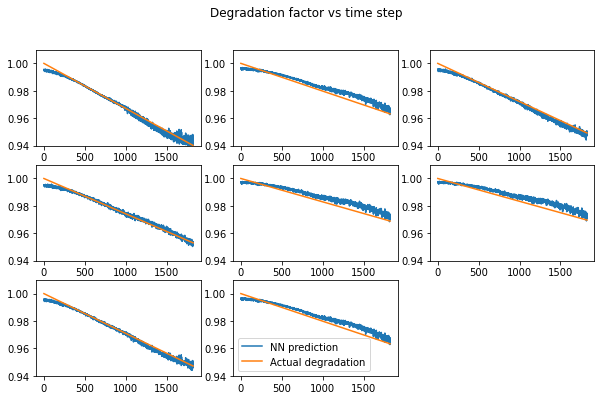

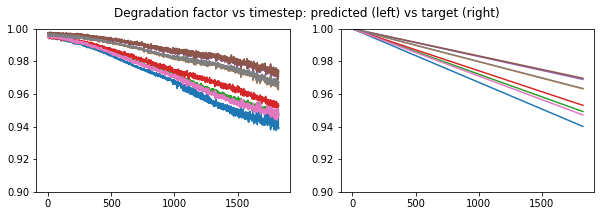

Displaying soil dataset


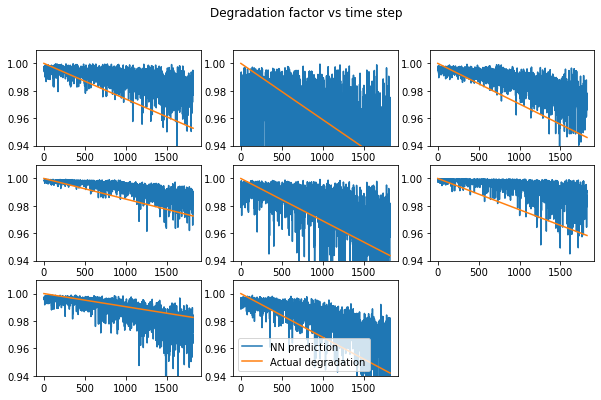

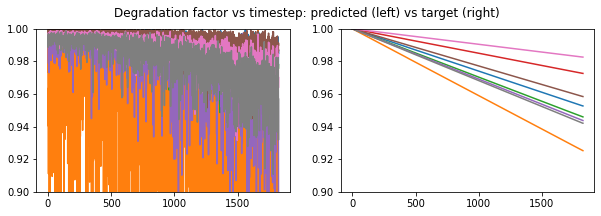

Displaying weather dataset


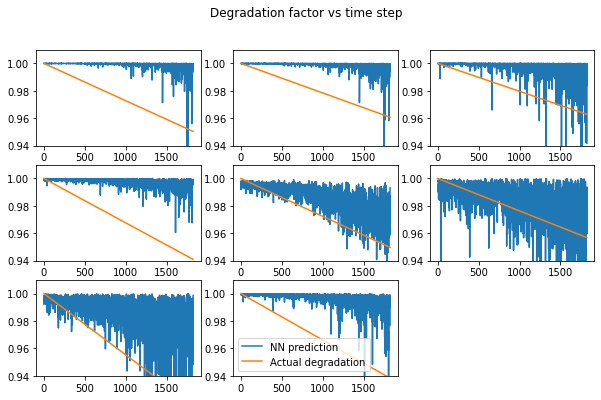

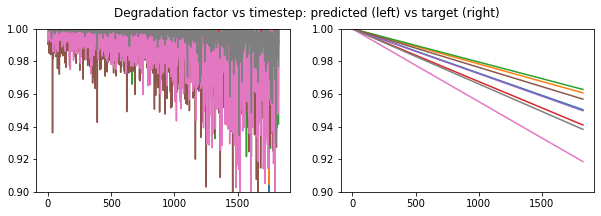

Displaying soil_weather dataset


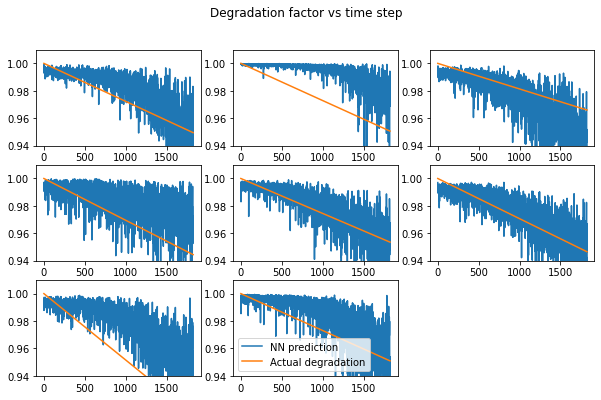

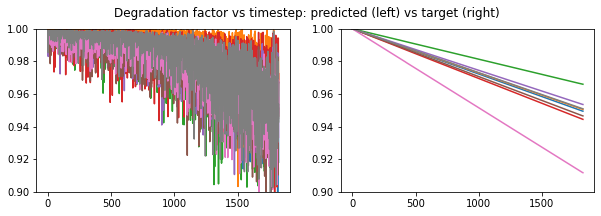

Displaying soil_weather_extra dataset


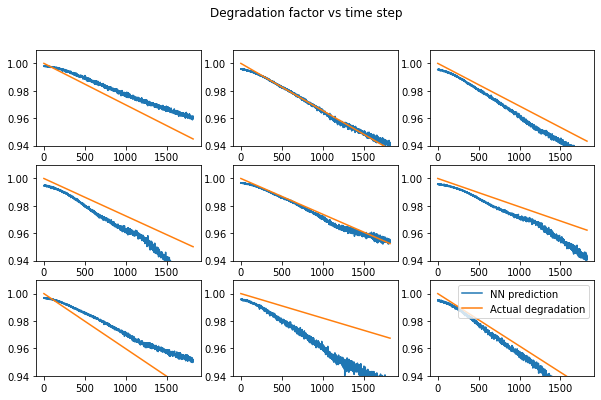

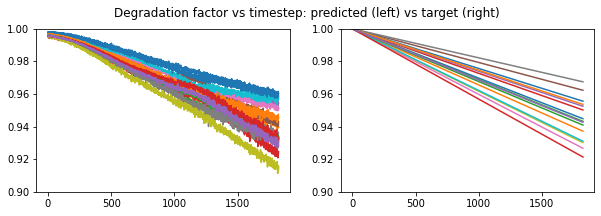

In [7]:
# Visualizing the predictions.
for dataset in datasets: 
    print(f"Displaying {dataset[1]} dataset")
    
    prediction = predictions[dataset[1]]
    y_test = y_tests[dataset[1]]
    
    plt.figure(figsize=(10,6))
    plt.tight_layout()
    plt.suptitle("Degradation factor vs time step")
    for i in range(0, min(len(prediction), 9)):
        plt.subplot(3,3,i+1)
        plt.ylim(0.94,1.01)
        plt.plot([x for x in prediction[i]])
        plt.plot([x for x in y_test[i]])
    plt.legend(['NN prediction','Actual degradation'])
    plt.show()

    plt.figure(figsize=(10,3))
    plt.suptitle("Degradation factor vs timestep: predicted (left) vs target (right)")
    plt.subplot(1,2,1)
    plt.ylim(0.90,1)
    for i in range(0,len(prediction)):
        plt.plot(prediction[i])
    plt.subplot(1,2,2)
    plt.ylim(0.90,1)
    for i in range(0,len(y_test)):
        plt.plot(y_test[i])
    plt.show()

Displaying basic dataset
RMSE is 0.003378522301112266


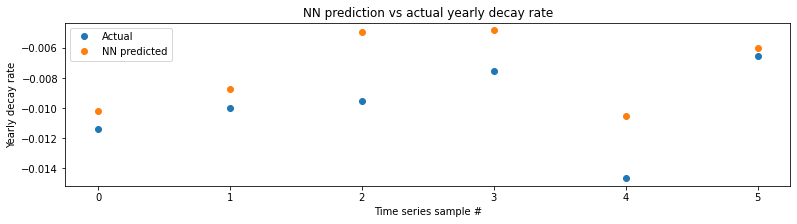

Displaying soil dataset
RMSE is 0.005947004788608638


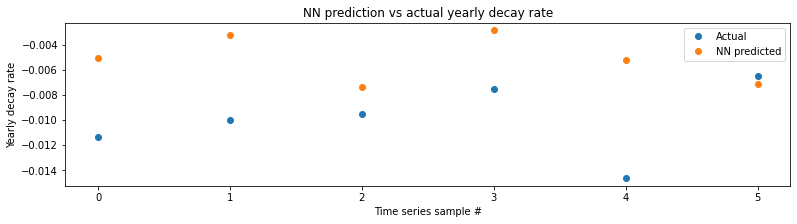

Displaying weather dataset
RMSE is 0.008336288340208196


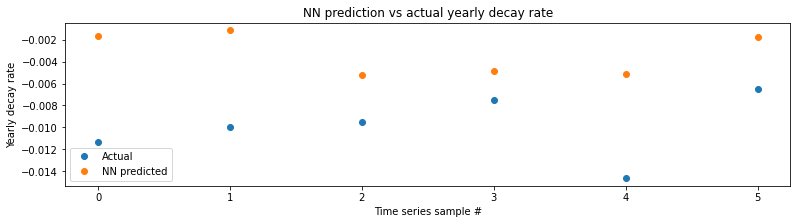

Displaying soil_weather dataset
RMSE is 0.004178897234057399


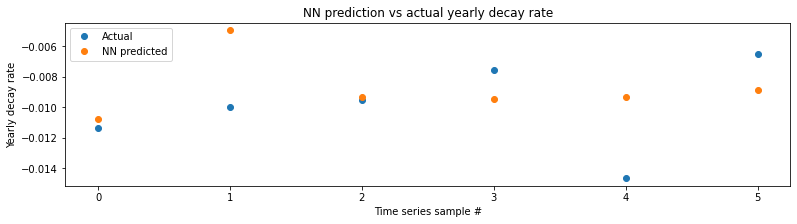

Displaying soil_weather_extra dataset
RMSE is 0.0032672344709191183


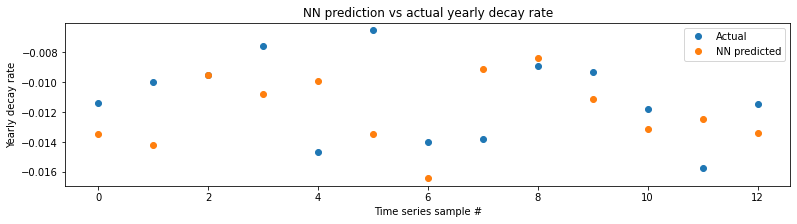

In [8]:
for dataset in datasets:
    # Plotting decay rate (predicted vs target)
    
    print(f"Displaying {dataset[1]} dataset")
    prediction = predictions[dataset[1]]
    
    model_pred = []
    degradation_rates_test = []
    for i in range(0, len(prediction)):
        model_pred.append(extract_yr_degrad(prediction[i, :]))
        degradation_rates_test.append(extract_yr_degrad(y_test[i]))
    mse = mean_squared_error(model_pred, degradation_rates_test)
    print(f"RMSE is {np.sqrt(mse)}")
    
    plt.figure(figsize=(13,3))
    plt.plot(degradation_rates_test[2:50], 'o')
    plt.plot(model_pred[2:50], 'o')
    plt.xlabel("Time series sample #")
    plt.ylabel("Yearly decay rate")
    plt.title("NN prediction vs actual yearly decay rate")
    plt.legend(["Actual","NN predicted"])
    plt.show()

Displaying basic dataset


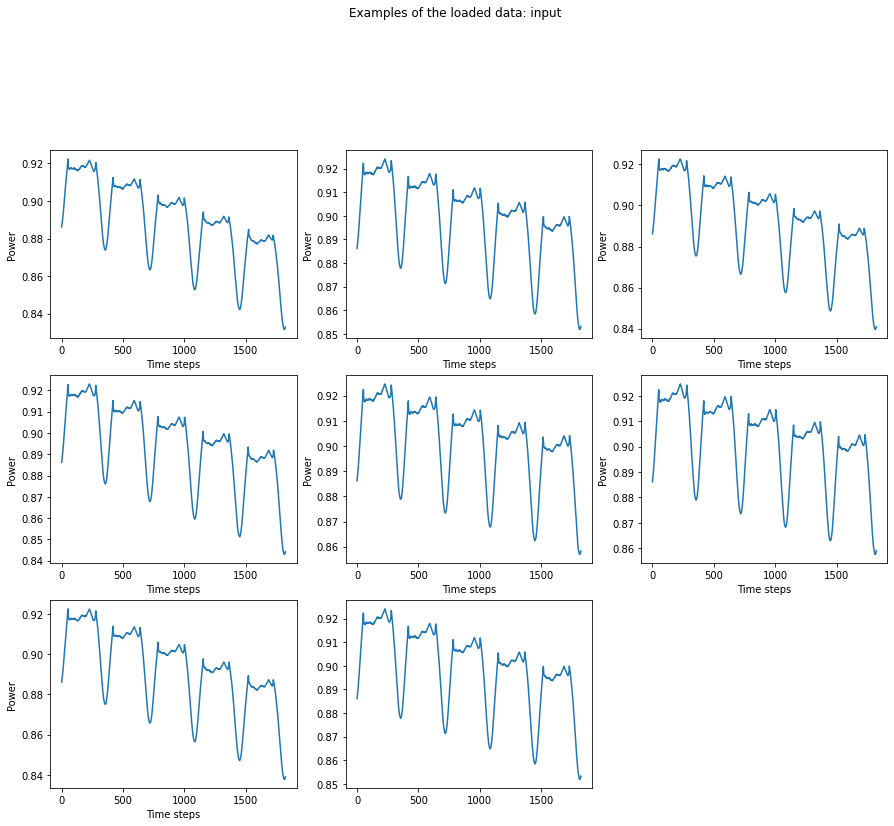

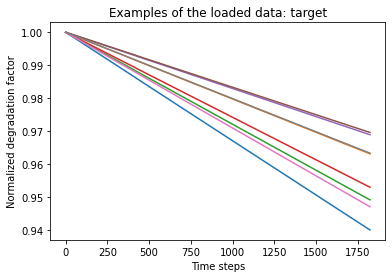

Displaying soil dataset


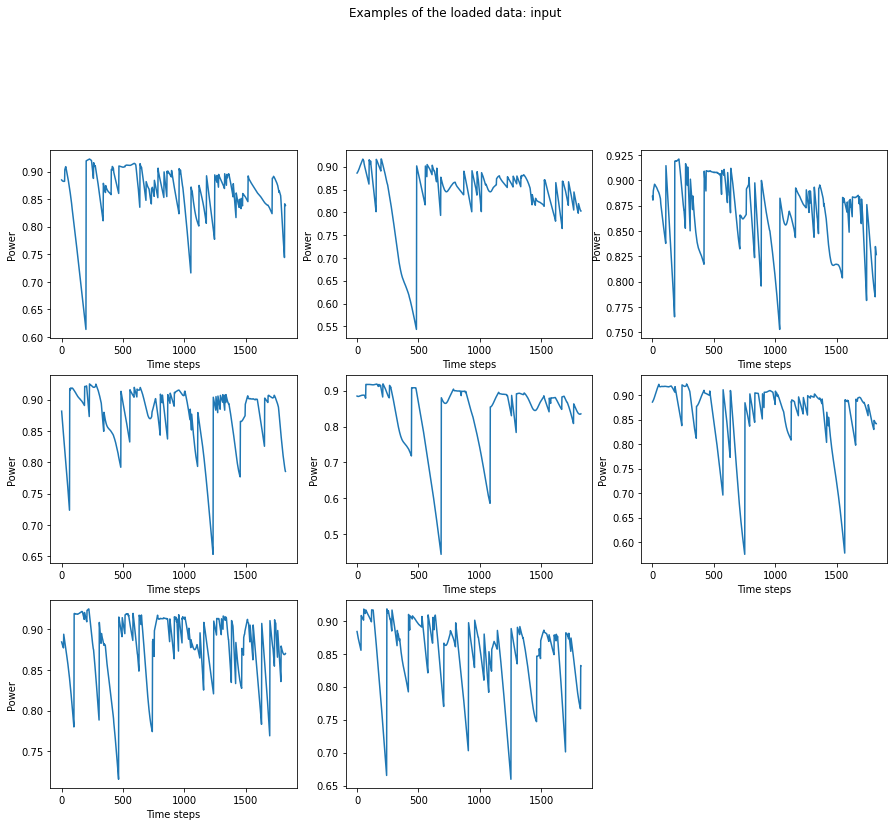

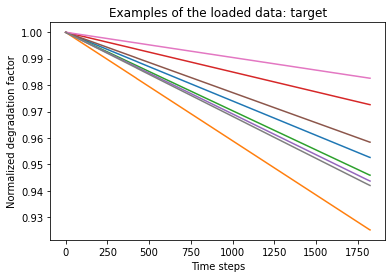

Displaying weather dataset


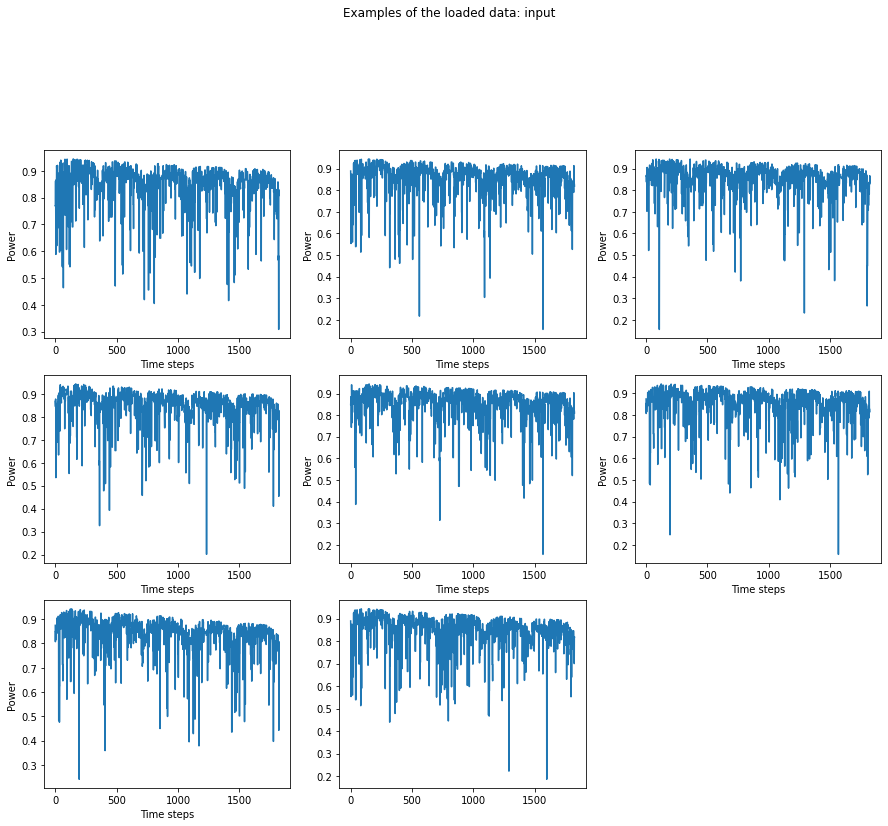

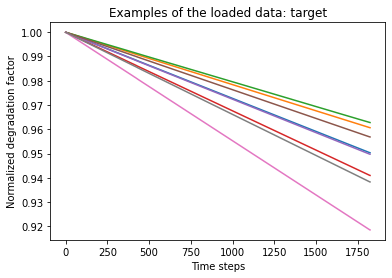

Displaying soil_weather dataset


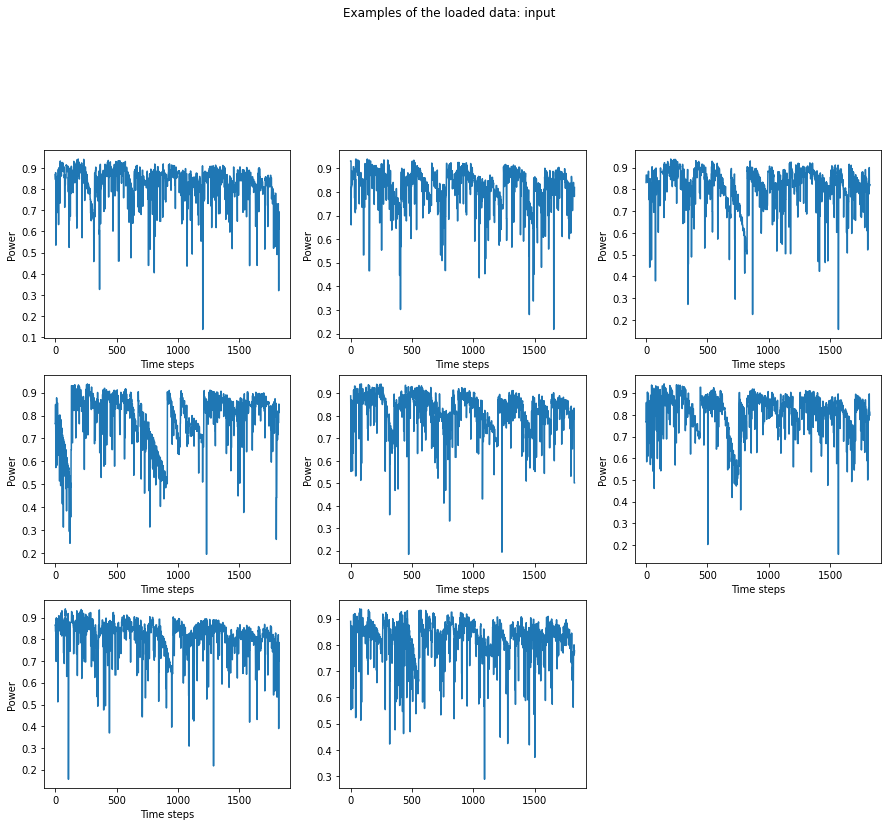

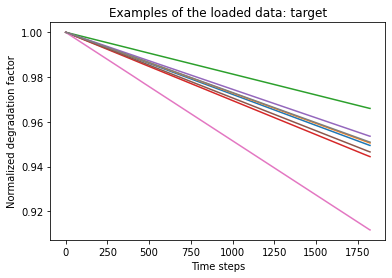

Displaying soil_weather_extra dataset


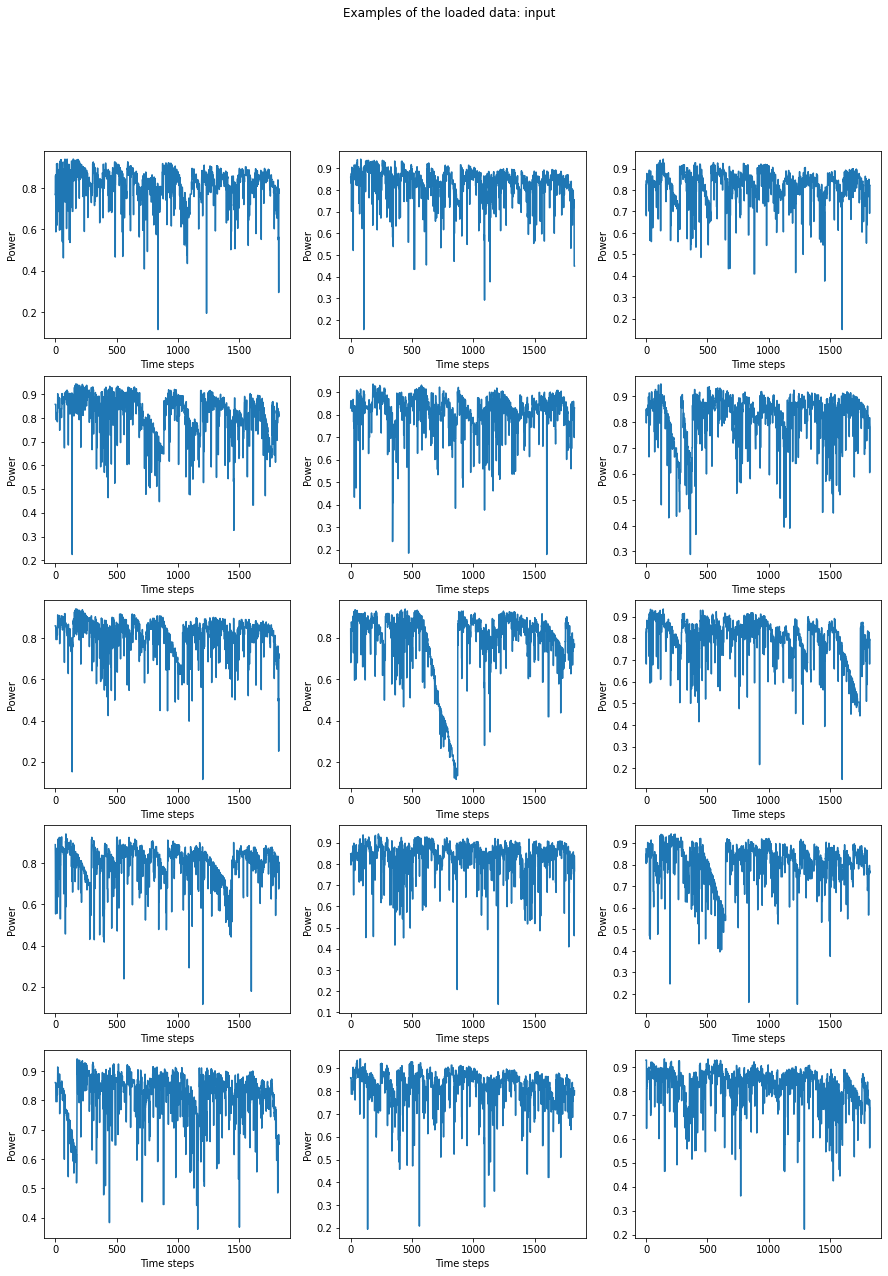

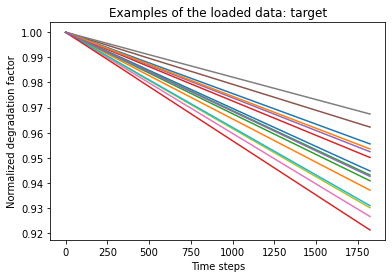

In [12]:
for dataset in datasets:
    print(f"Displaying {dataset[1]} dataset")
    X = X_tests[dataset[1]]
    y = y_tests[dataset[1]]
    
    plt.figure(figsize=(15,20))
    plt.suptitle("Examples of the loaded data: input")
    for i,s in enumerate(X):
        plt.xlabel("Time steps")
        plt.ylabel("Power")
        plt.subplot(5,3,i+1)
        plt.plot(s)
    plt.show()

    plt.figure()
    plt.title("Examples of the loaded data: target")
    plt.xlabel("Time steps")
    plt.ylabel("Normalized degradation factor")
    for s in y:
        plt.plot(s)
    plt.show()